In [1]:
from utilities import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import aesara.tensor as at
import theano
#from create_training_instance_dictionary_with_covariates import *
#from feature_extraction import *
#from sample_from_full_model import *
#from sample_from_BNN_model_advi import *
# Initialize random number generator
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


In [2]:
# Generate simulated data with interactions 
true_sigma_obs = 0.0
N_patients = 100

# True parameter values
P = 3 # Number of covariates
P0 = int(P / 2) # A guess of the true number of nonzero parameters is needed for defining the global shrinkage parameter
X_mean = np.repeat(0,P)
X_std = np.repeat(0.5,P)
#X = np.random.normal(X_mean, X_std, size=(N_patients,P))
X = np.random.uniform(-1, 1, size=(N_patients,P))
X = pd.DataFrame(X, columns = ["Covariate "+str(ii+1) for ii in range(P)])
# These are the true parameters for x1 = 0 (median):
rho_s_population = -0.005
rho_r_population = 0.001
pi_r_population = 0.4
psi_population = 50
theta_rho_s_population_for_x_equal_to_zero = np.log(-rho_s_population)
theta_rho_r_population_for_x_equal_to_zero = np.log(rho_r_population)
theta_pi_r_population_for_x_equal_to_zero  = np.log(pi_r_population/(1-pi_r_population))

true_omega = np.array([0.05, 0.10, 0.15])
true_alpha = np.array([theta_rho_s_population_for_x_equal_to_zero, theta_rho_r_population_for_x_equal_to_zero, theta_pi_r_population_for_x_equal_to_zero])
true_beta_rho_s = np.zeros(P)
true_beta_rho_s[0] = 0.8
true_beta_rho_s[1] = 0
interaction_beta_x1_x2_rho_s = -1
true_beta_rho_r = np.zeros(P)
true_beta_rho_r[0] = 0.7
true_beta_rho_r[1] = 1.0
true_beta_pi_r = np.zeros(P)
true_beta_pi_r[0] = 0.0
true_beta_pi_r[1] = 1.1

print("true_alpha[0]:", true_alpha[0])
print("true_alpha[1]:", true_alpha[1])
print("true_alpha[2]:", true_alpha[2])
print("true_beta_rho_s: ", true_beta_rho_s)
print("true_beta_rho_r: ", true_beta_rho_r)
print("true_beta_pi_r: ", true_beta_pi_r)

# This could be a function: 
#   X, patient_dictionary = generate_simulated_patients(M_number_of_measurements, days_between_measurements, measurement_times, treatment_history, interaction_beta_x1_x2_rho_s)

M_number_of_measurements = 5
days_between_measurements = int(1500/M_number_of_measurements)
measurement_times = days_between_measurements * np.linspace(0, M_number_of_measurements-1, M_number_of_measurements)
treatment_history = np.array([Treatment(start=0, end=measurement_times[-1], id=1)])

#expected_theta_1 = np.reshape(true_alpha[0] + np.dot(X, true_beta_rho_s), (N_patients,1))
#print((true_alpha[0] + np.dot(X, true_beta_rho_s)).shape)
#print((interaction_beta_x1_x2_rho_s*X["Covariate 1"]*(X["Covariate 2"].T)).shape)
expected_theta_1 = np.reshape(true_alpha[0] + np.dot(X, true_beta_rho_s) + np.ravel(interaction_beta_x1_x2_rho_s*X["Covariate 1"]*(X["Covariate 2"].T)), (N_patients,1))
print(expected_theta_1.shape)
expected_theta_2 = np.reshape(true_alpha[1] + np.dot(X, true_beta_rho_r), (N_patients,1))
expected_theta_3 = np.reshape(true_alpha[2] + np.dot(X, true_beta_pi_r), (N_patients,1))

true_theta_rho_s = expected_theta_1 #np.random.normal(expected_theta_1, true_omega[0])
true_theta_rho_r = expected_theta_2 #np.random.normal(expected_theta_2, true_omega[1])
true_theta_pi_r  = expected_theta_3 #np.random.normal(expected_theta_3, true_omega[2])

true_omega_for_psi = 0.1
true_theta_psi = np.random.normal(np.log(psi_population), true_omega_for_psi, size=N_patients)
true_rho_s = - np.exp(true_theta_rho_s)
true_rho_r = np.exp(true_theta_rho_r)
true_pi_r  = 1/(1+np.exp(-true_theta_pi_r))
true_psi = np.exp(true_theta_psi)

patient_dictionary = {}
for training_instance_id in range(N_patients):
    psi_patient_i   = true_psi[training_instance_id]
    pi_r_patient_i  = true_pi_r[training_instance_id]
    rho_r_patient_i = true_rho_r[training_instance_id]
    rho_s_patient_i = true_rho_s[training_instance_id]
    these_parameters = Parameters(Y_0=psi_patient_i, pi_r=pi_r_patient_i, g_r=rho_r_patient_i, g_s=rho_s_patient_i, k_1=0, sigma=true_sigma_obs)
    this_patient = Patient(these_parameters, measurement_times, treatment_history, name=str(training_instance_id))
    patient_dictionary[training_instance_id] = this_patient
    #plot_true_mprotein_with_observations_and_treatments_and_estimate(these_parameters, this_patient, estimated_parameters=[], PLOT_ESTIMATES=False, plot_title=str(training_instance_id), savename="./plots/Bayes_simulated_data/"+str(training_instance_id))

true_alpha[0]: -5.298317366548036
true_alpha[1]: -6.907755278982137
true_alpha[2]: -0.4054651081081643
true_beta_rho_s:  [0.8 0.  0. ]
true_beta_rho_r:  [0.7 1.  0. ]
true_beta_pi_r:  [0.  1.1 0. ]
(100, 1)


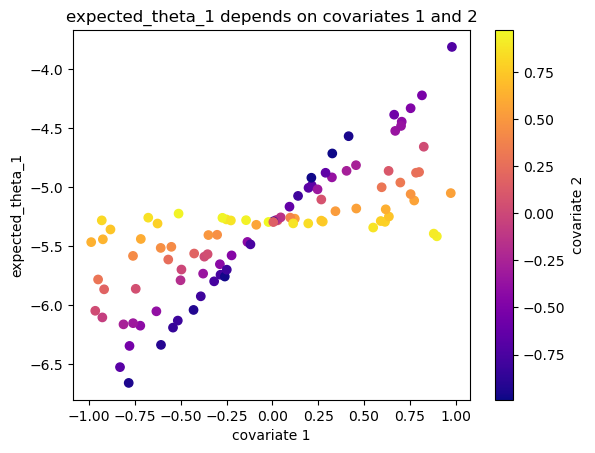

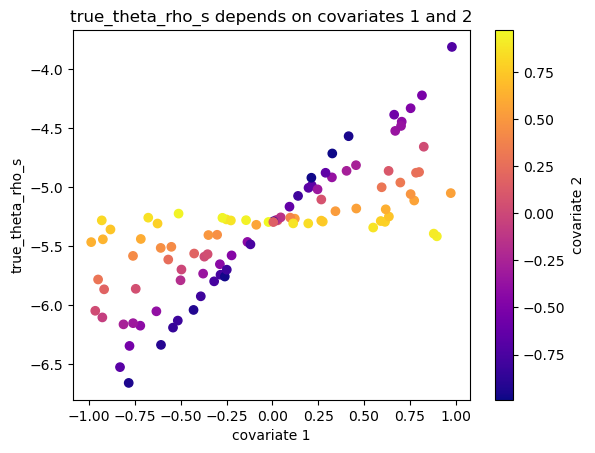

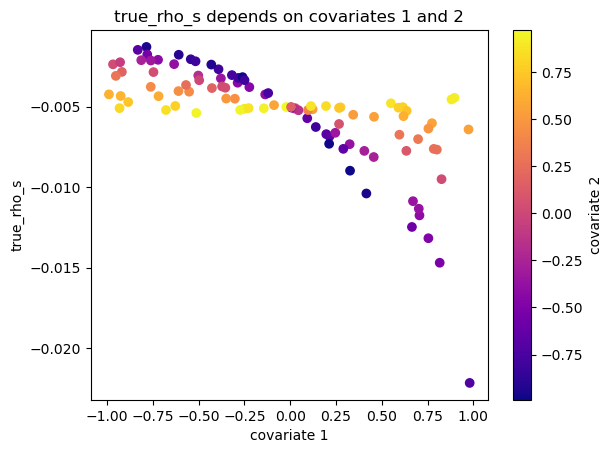

In [3]:
# Visualize parameter dependancy on covariates 
VISZ = True
if VISZ:
    color_array = X["Covariate 2"].to_numpy()

    fig, ax = plt.subplots()
    ax.set_title("expected_theta_1 depends on covariates 1 and 2")
    points = ax.scatter(X["Covariate 1"], expected_theta_1, c=color_array, cmap="plasma")
    ax.set_xlabel("covariate 1")
    ax.set_ylabel("expected_theta_1")
    cbar = fig.colorbar(points)
    cbar.set_label('covariate 2', rotation=90)
    plt.show()

    fig, ax = plt.subplots()
    ax.set_title("true_theta_rho_s depends on covariates 1 and 2")
    points = ax.scatter(X["Covariate 1"], true_theta_rho_s, c=color_array, cmap="plasma")
    ax.set_xlabel("covariate 1")
    ax.set_ylabel("true_theta_rho_s")
    cbar = fig.colorbar(points)
    cbar.set_label('covariate 2', rotation=90)
    plt.show()

    fig, ax = plt.subplots()
    ax.set_title("true_rho_s depends on covariates 1 and 2")
    points = ax.scatter(X["Covariate 1"], true_rho_s, c=color_array, cmap="plasma")
    ax.set_xlabel("covariate 1")
    ax.set_ylabel("true_rho_s")
    cbar = fig.colorbar(points)
    cbar.set_label('covariate 2', rotation=90)
    plt.show()

In [4]:
# Transpose and check that dimensions are correct
Y = np.transpose(np.array([patient.Mprotein_values for _, patient in patient_dictionary.items()]))
t = np.transpose(np.array([patient.measurement_times for _, patient in patient_dictionary.items()]))
yi0 = np.array([patient.Mprotein_values[0] for _, patient in patient_dictionary.items()])
yi0 = np.maximum(yi0, 1e-5)
#print("Y:\n", Y)
#print("t:\n", t)
#print("yi0:\n", yi0)
#print("X:\n", X)
X_not_transformed = X.copy().T
print(X_not_transformed.columns.values)
#X = X.T
print("Shapes:")
print("Y:", Y.shape)
print("t:", t.shape)
print("yi0:", yi0.shape)
print("X:", X.shape)
print("Done generating data")

assert X.shape[0] == len(patient_dictionary)
N_cases, P = X.shape
print("N_cases:", N_cases)
print(patient_dictionary[0].treatment_history[-1].end)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Shapes:
Y: (5, 100)
t: (5, 100)
yi0: (100,)
X: (100, 3)
Done generating data
N_cases: 100
1200.0


In [5]:
# Check that histories stop at the last M protein measurement
print(patient_dictionary[0].treatment_history[-1].end)
print(patient_dictionary[0].measurement_times[-1])

1200.0
1200.0


Running simdata_BNN_M_5_P_3_N_cases_100_psi_prior_lognormal_N_samples_5000_N_tuning_0_target_accept_0.99_max_treedepth_10_FUNNEL_REPARAMETRIZATION_False
    Covariate 1  Covariate 2  Covariate 3
0     -0.250920     0.901429     0.463988
1      0.197317    -0.687963    -0.688011
2     -0.883833     0.732352     0.202230
3      0.416145    -0.958831     0.939820
4      0.664885    -0.575322    -0.636350
..          ...          ...          ...
95    -0.928115    -0.068804     0.085289
96    -0.426917     0.181667    -0.939000
97    -0.925304     0.645201    -0.279619
98    -0.745879     0.044487     0.539987
99    -0.568358     0.245781    -0.829305

[100 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
Max(Y): 10685.882543682976
Max(t): 1200.0


/home/evenmm/anaconda3/envs/second_pymc_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/evenmm/anaconda3/envs/second_pymc_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


3


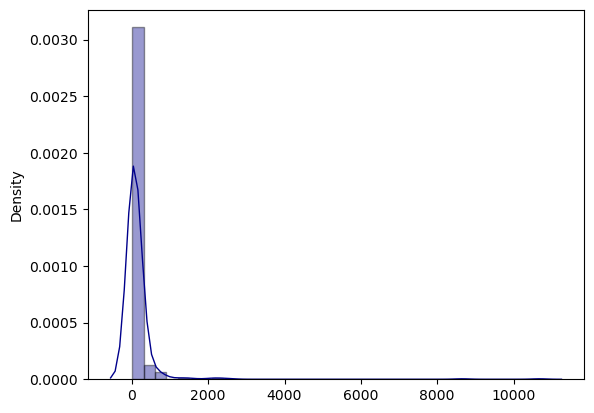

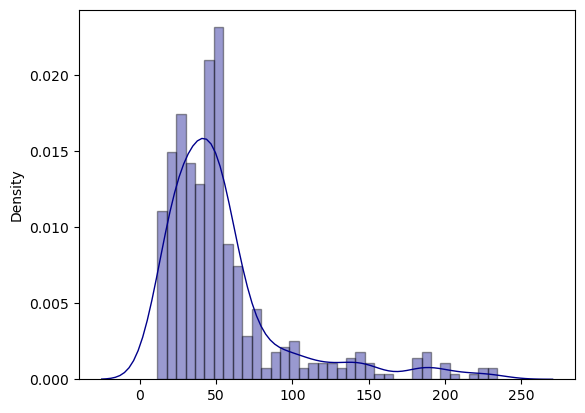

In [13]:
# Sample from full model
psi_prior="lognormal"
N_samples = 5000
N_tuning = 0
N_advi = 50000 #500000
target_accept = 0.99
max_treedepth = 10
FUNNEL_REPARAMETRIZATION = False
name = "simdata_BNN_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_cases_"+str(N_cases)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+"_N_tuning_"+str(N_tuning)+"_target_accept_"+str(target_accept)+"_max_treedepth_"+str(max_treedepth)+"_FUNNEL_REPARAMETRIZATION_"+str(FUNNEL_REPARAMETRIZATION)
print("Running "+name)

# Initialize random number generator
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
##############################
# Function argument shapes: 
# X is an (N_patients, P) shaped pandas dataframe
# patient dictionary contains N_patients patients in the same order as X
 #sample_from_BNN_model_advi(X, patient_dictionary, ...
def construct_nn(ann_input, ann_Y, ann_t, ann_yi0, name, N_samples=5000, N_advi=500000, target_accept=0.99, max_treedepth=10, psi_prior="lognormal", FUNNEL_REPARAMETRIZATION=False, FUNNEL_WEIGHTS = False):
    #X = pd.DataFrame(ann_input.get_value(), columns = ["Covariate "+str(ii+1) for ii in range(len(ann_input))])
    X = ann_input.get_value()
    print(X)
    print(type(X))
    N_patients, P = X.shape
    P0 = int(P / 2) # A guess of the true number of nonzero parameters is needed for defining the global shrinkage parameter
    X_not_transformed = X.copy()
    X = X.T
    #patient_dictionary = ann_output.get_value()
    #print(len(patient_dictionary))
    #Y = np.transpose(np.array([patient.Mprotein_values for _, patient in patient_dictionary.items()]))
    #t = np.transpose(np.array([patient.measurement_times for _, patient in patient_dictionary.items()]))
    #yi0 = np.maximum(1e-5, np.array([patient.Mprotein_values[0] for _, patient in patient_dictionary.items()]))
    Y = ann_Y.get_value()
    t = ann_t.get_value()
    yi0 = ann_yi0.get_value()
    # Dimensions: 
    # X: (P, N_cases)
    # y: (M_max, N)
    # t: (M_max, N)

    print("Max(Y):", np.amax(Y))
    print("Max(t):", np.amax(t))
    viz_Y = Y[Y<250]
    plt.figure()
    sns.distplot(Y, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1, 'gridsize':100})
    plt.savefig("./plots/posterior_plots/"+name+"-plot_density.png")
    plt.close
    plt.figure()
    sns.distplot(viz_Y, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1, 'gridsize':100})
    plt.savefig("./plots/posterior_plots/"+name+"-plot_density_lessthan_250.png")
    plt.close
    if psi_prior not in ["lognormal", "normal"]:
        print("Unknown prior option specified for psi; Using 'lognormal' prior")
        psi_prior = "lognormal"

    n_hidden = 3
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[0], n_hidden) #.astype(floatX)
    print(X.shape[0])
    init_2 = np.random.randn(n_hidden, n_hidden) #.astype(floatX)
    init_out = np.random.randn(n_hidden) #.astype(floatX)

    with pm.Model(coords={"predictors": X_not_transformed.columns.values}) as neural_net_model:
        # Observation noise (std)
        sigma_obs = pm.HalfNormal("sigma_obs", sigma=1)
        # alpha
        alpha = pm.Normal("alpha",  mu=np.array([np.log(0.002), np.log(0.002), np.log(0.5/(1-0.5))]),  sigma=1, shape=3)
        # covariate effects through multilayer neural network
        # Weights from input to hidden layer
        # Funnel reparametrized weights: 
        sigma_weights = pm.HalfNormal("sigma_weights", sigma=1)
        if FUNNEL_WEIGHTS == True:
            # Weights input to 1st layer
            weights_in_rho_s_offset = pm.Normal("weights_in_rho_s_offset ", mu=0, sigma=1, shape=(X.shape[0], n_hidden))
            weights_in_rho_r_offset = pm.Normal("weights_in_rho_r_offset ", mu=0, sigma=1, shape=(X.shape[0], n_hidden))
            weights_in_pi_r_offset = pm.Normal("weights_in_pi_r_offset ", mu=0, sigma=1, shape=(X.shape[0], n_hidden))
            weights_in_rho_s = pm.Deterministic(("weights_in_rho_s", weights_in_rho_s_offset * sigma_weights)) # sigma_weights_in_rho_s))
            weights_in_rho_r = pm.Deterministic(("weights_in_rho_r", weights_in_rho_r_offset * sigma_weights)) # sigma_weights_in_rho_r))
            weights_in_pi_r = pm.Deterministic(("weights_in_pi_r", weights_in_pi_r_offset * sigma_weights)) # sigma_weights_in_pi_r))
            # Weights from 1st to 2nd layer
            weights_out_rho_s_offset = pm.Normal("weights_out_rho_s_offset ", mu=0, sigma=1, shape=(n_hidden, ))
            weights_out_rho_r_offset = pm.Normal("weights_out_rho_r_offset ", mu=0, sigma=1, shape=(n_hidden, ))
            weights_out_pi_r_offset = pm.Normal("weights_out_pi_r_offset ", mu=0, sigma=1, shape=(n_hidden, ))
            weights_out_rho_s = pm.Deterministic(("weights_out_rho_s", weights_out_rho_s_offset * sigma_weights)) #sigma_weights_out_rho_s
            weights_out_rho_r = pm.Deterministic(("weights_out_rho_r", weights_out_rho_r_offset * sigma_weights)) #sigma_weights_out_rho_r
            weights_out_pi_r = pm.Deterministic(("weights_out_pi_r", weights_out_pi_r_offset * sigma_weights)) #sigma_weights_out_pi_r
        else:
            # Weights input to 1st layer
            weights_in_rho_s = pm.Normal('weights_in_rho_s', 0, sigma=sigma_weights, shape=(X.shape[0], n_hidden), initval=init_1) # sigma=sigma_weights_in_rho_s
            weights_in_rho_r = pm.Normal('weights_in_rho_r', 0, sigma=sigma_weights, shape=(X.shape[0], n_hidden), initval=init_1) # sigma=sigma_weights_in_rho_r
            weights_in_pi_r = pm.Normal('weights_in_pi_r', 0, sigma=sigma_weights, shape=(X.shape[0], n_hidden), initval=init_1) # sigma=sigma_weights_in_pi_r
            # Weights from 1st to 2nd layer
            weights_out_rho_s = pm.Normal('weights_out_rho_s', 0, sigma=sigma_weights, shape=(n_hidden, ), initval=init_out) # sigma=sigma_weights_out_rho_s
            weights_out_rho_r = pm.Normal('weights_out_rho_r', 0, sigma=sigma_weights, shape=(n_hidden, ), initval=init_out) # sigma=sigma_weights_out_rho_r
            weights_out_pi_r = pm.Normal('weights_out_pi_r', 0, sigma=sigma_weights, shape=(n_hidden, ), initval=init_out) # sigma=sigma_weights_out_pi_r
        # Original was with all sigma_weights = 1 
        
        # offsets for each node between each layer 
        sigma_bias = pm.HalfNormal("sigma_bias", sigma=1, shape=(1,n_hidden))
        bias_in_rho_s = pm.Normal("bias_in_rho_s", mu=0, sigma=sigma_bias, shape=(1,n_hidden)) # sigma=sigma_bias_in_rho_s
        bias_in_rho_r = pm.Normal("bias_in_rho_r", mu=0, sigma=sigma_bias, shape=(1,n_hidden)) # sigma=sigma_bias_in_rho_r
        bias_in_pi_r = pm.Normal("bias_in_pi_r", mu=0, sigma=sigma_bias, shape=(1,n_hidden)) # sigma=sigma_bias_in_pi_r

        # Leaky RELU
        pre_act_1_rho_s = pm.math.dot(X_not_transformed, weights_in_rho_s) + bias_in_rho_s
        pre_act_1_rho_r = pm.math.dot(X_not_transformed, weights_in_rho_r) + bias_in_rho_r
        pre_act_1_pi_r = pm.math.dot(X_not_transformed, weights_in_pi_r) + bias_in_pi_r
        act_1_rho_s = pm.math.switch(pre_act_1_rho_s > 0, pre_act_1_rho_s, pre_act_1_rho_s * 0.01)
        act_1_rho_r = pm.math.switch(pre_act_1_rho_r > 0, pre_act_1_rho_r, pre_act_1_rho_r * 0.01)
        act_1_pi_r = pm.math.switch(pre_act_1_pi_r > 0, pre_act_1_pi_r, pre_act_1_pi_r * 0.01)

        # Output activation function is just unit transform for prediction model
        act_out_rho_s = pm.math.dot(act_1_rho_s, weights_out_rho_s)
        act_out_rho_r = pm.math.dot(act_1_rho_r, weights_out_rho_r)
        act_out_pi_r = pm.math.dot(act_1_pi_r, weights_out_pi_r)

        # Latent variables theta
        omega = pm.HalfNormal("omega",  sigma=1, shape=3) # Patient variability in theta (std)
        if FUNNEL_REPARAMETRIZATION == True: 
            # Reparametrized to escape/explore the funnel of Hell (https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/):
            theta_rho_s_offset = pm.Normal('theta_rho_s_offset', mu=0, sigma=1, shape=N_patients)
            theta_rho_r_offset = pm.Normal('theta_rho_r_offset', mu=0, sigma=1, shape=N_patients)
            theta_pi_r_offset  = pm.Normal('theta_pi_r_offset',  mu=0, sigma=1, shape=N_patients)
            theta_rho_s = pm.Deterministic("theta_rho_s", (alpha[0] + act_out_rho_s + theta_rho_s_offset * omega[0]))
            theta_rho_r = pm.Deterministic("theta_rho_r", (alpha[1] + act_out_rho_r + theta_rho_r_offset * omega[1]))
            theta_pi_r  = pm.Deterministic("theta_pi_r",  (alpha[2] + act_out_pi_r + theta_pi_r_offset  * omega[2]))
        else: 
            # Original
            theta_rho_s = pm.Normal("theta_rho_s", mu= alpha[0] + act_out_rho_s, sigma=omega[0]) # Individual random intercepts in theta to confound effects of X
            theta_rho_r = pm.Normal("theta_rho_r", mu= alpha[1] + act_out_rho_r, sigma=omega[1]) # Individual random intercepts in theta to confound effects of X
            theta_pi_r  = pm.Normal("theta_pi_r",  mu= alpha[2] + act_out_pi_r,  sigma=omega[2]) # Individual random intercepts in theta to confound effects of X
        # psi: True M protein at time 0
        # 1) Normal. Fast convergence, but possibly negative tail 
        if psi_prior=="normal":
            psi = pm.Normal("psi", mu=yi0, sigma=sigma_obs, shape=N_patients) # Informative. Centered around the patient specific yi0 with std=observation noise sigma 
        # 2) Lognormal. Works if you give it time to converge
        if psi_prior=="lognormal":
            xi = pm.HalfNormal("xi", sigma=1)
            log_psi = pm.Normal("log_psi", mu=np.log(yi0+1e-8), sigma=xi, shape=N_patients)
            psi = pm.Deterministic("psi", np.exp(log_psi))
        # 3) Exact but does not work: 
        #log_psi = pm.Normal("log_psi", mu=np.log(yi0) - np.log( (sigma_obs**2)/(yi0**2) - 1), sigma=np.log( (sigma_obs**2)/(yi0**2) - 1), shape=N_patients) # Informative. Centered around the patient specific yi0 with std=observation noise sigma_obs 
        #psi = pm.Deterministic("psi", np.exp(log_psi))

        # Transformed latent variables 
        rho_s = pm.Deterministic("rho_s", -np.exp(theta_rho_s))
        rho_r = pm.Deterministic("rho_r", np.exp(theta_rho_r))
        pi_r  = pm.Deterministic("pi_r", 1/(1+np.exp(-theta_pi_r)))

        # Observation model 
        mu_Y = psi * (pi_r*np.exp(rho_r*t) + (1-pi_r)*np.exp(rho_s*t))

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal("Y_obs", mu=mu_Y, sigma=sigma_obs, observed=Y)
    return neural_net_model

#ann_input = theano.shared([X[cov].values for cov in X.columns.values])
ann_input = theano.shared(X)
#ann_output = theano.shared(patient_dictionary)
ann_Y = theano.shared(np.transpose(np.array([patient.Mprotein_values for _, patient in patient_dictionary.items()])))
ann_t = theano.shared(np.transpose(np.array([patient.measurement_times for _, patient in patient_dictionary.items()])))
ann_yi0 = theano.shared(np.maximum(1e-5, np.array([patient.Mprotein_values[0] for _, patient in patient_dictionary.items()])))

neural_net_model = construct_nn(ann_input, ann_Y, ann_t, ann_yi0, name, N_samples=N_samples, N_advi=N_advi, target_accept=target_accept, max_treedepth=max_treedepth, psi_prior=psi_prior, FUNNEL_REPARAMETRIZATION=FUNNEL_REPARAMETRIZATION)

In [15]:
#with neural_net_model:
#    prior_samples = pm.sample_prior_predictive(200)
#raveled_Y_true = np.ravel(Y)
#raveled_Y_sample = np.ravel(prior_samples.prior_predictive["Y_obs"])
## Below plotlimit_prior
#plotlimit_prior = 1000
#plt.figure()
#az.plot_dist(raveled_Y_true[raveled_Y_true<plotlimit_prior], color="C1", label="observed", bw=3)
#az.plot_dist(raveled_Y_sample[raveled_Y_sample<plotlimit_prior], label="simulated", bw=3)
#plt.title("Samples from prior compared to observations, for Y<plotlimit_prior")
#plt.xlabel("Y (M protein)")
#plt.ylabel("Frequency")
#plt.savefig("./plots/posterior_plots/"+name+"-plot_prior_samples_below_"+str(plotlimit_prior)+".png")
#plt.close()
## All samples: 
#plt.figure()
#az.plot_dist(raveled_Y_true, color="C1", label="observed", bw=3)
#az.plot_dist(raveled_Y_sample, label="simulated", bw=3)
#plt.title("Samples from prior compared to observations")
#plt.xlabel("Y (M protein)")
#plt.ylabel("Frequency")
#plt.savefig("./plots/posterior_plots/"+name+"-plot_prior_samples.png")
#plt.close()
# Draw samples from posterior:
with neural_net_model:
    #idata = pm.sample(N_samples, tune=N_tuning, random_seed=42, target_accept=target_accept, max_treedepth=max_treedepth)
    inference = pm.ADVI()
    approx = pm.fit(n=N_advi, method=inference)
    trace = approx.sample(draws=N_samples)
    idata = trace
#idata = sample_from_BNN_model_advi(X, patient_dictionary, name, N_samples=N_samples, N_advi=N_advi, target_accept=target_accept, max_treedepth=max_treedepth, psi_prior=psi_prior, FUNNEL_REPARAMETRIZATION=FUNNEL_REPARAMETRIZATION)

# This is an xArray: https://docs.xarray.dev/en/v2022.11.0/user-guide/data-structures.html
print("Done sampling")

AssertionError: 

In [ ]:
# Convergence checks
def quasi_geweke_test(idata, first=0.1, last=0.5, intervals=20):
    print("Running Geweke test...")
    convergence_flag = True
    for var_name in ['alpha', 'omega', 'theta_rho_s', 'theta_rho_r', 'theta_pi_r', 'rho_s', 'rho_r', 'pi_r']:
        sample_shape = idata.posterior[var_name].shape
        n_chains = sample_shape[0]
        n_samples = sample_shape[1]
        var_dims = sample_shape[2]
        for chain in range(n_chains):
            for dim in range(var_dims):
                all_samples = np.ravel(idata.posterior[var_name][chain,:,dim])
                first_part = all_samples[0:int(n_samples*first)]
                last_part = all_samples[n_samples-int(n_samples*last):n_samples]
                z_score = (np.mean(first_part)-np.mean(last_part)) / np.sqrt(np.var(first_part)+np.var(last_part))
                if abs(z_score) >= 1.960:
                    convergence_flag = False
                    print("Seems like chain",chain,"has not converged in",var_name,"dimension",dim,": z_score is",z_score)
    for var_name in ['sigma_obs']:
        all_samples = np.ravel(idata.posterior[var_name])
        n_samples = len(all_samples)
        first_part = all_samples[0:int(n_samples*first)]
        last_part = all_samples[n_samples-int(n_samples*last):n_samples]
        z_score = (np.mean(first_part)-np.mean(last_part)) / np.sqrt(np.var(first_part)+np.var(last_part))
        if abs(z_score) >= 1.960:
            convergence_flag = False
            print("Seems like chain",chain,"has not converged in",var_name,"dimension",dim,": z_score is",z_score)
    if convergence_flag:
        print("All chains seem to have converged.")
    return 0

quasi_geweke_test(idata, first=0.1, last=0.5)

In [ ]:
# Autocorrelation plots: 
az.plot_autocorr(idata, var_names=["sigma_obs"]);
#az.plot_autocorr(idata, var_names=["alpha"]);
#az.plot_autocorr(idata, var_names=["omega"]);

In [ ]:
# Posterior means 
#print('Posterior average of alpha:\n', np.mean(idata.posterior['alpha'], axis=(0,1)))
#print('\nPosterior average of omega:\n', np.mean(idata.posterior['omega'], axis=(0,1)))
#print('\nPosterior average of sigma_obs:\n', np.mean(idata.posterior['sigma_obs'], axis=(0,1)))

In [ ]:
az.plot_trace(idata, var_names=('alpha', 'omega', 'sigma_obs'), combined=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_group_parameters.png")

In [ ]:
# Plot weights in_1 rho_s
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_in_rho_s'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_in_1_rho_s.png")
# There is also an effect where there are less resistant cells for the older patients.

In [ ]:
# Plot weights in_1 rho_r
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_in_rho_r'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_in_1_rho_r.png")
# There is also an effect where there are less resistant cells for the older patients.

In [ ]:
# Plot weights in_1 pi_r
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_in_pi_r'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_in_1_pi_r.png")
# There is also an effect where there are less resistant cells for the older patients.

In [ ]:
# Plot weights 2_out rho_s
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_out_rho_s'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_out_rho_s.png")
# There is also an effect where there are less resistant cells for the older patients.

# Plot weights 2_out rho_r
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_out_rho_r'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_out_rho_r.png")
# There is also an effect where there are less resistant cells for the older patients.

# Plot weights 2_out pi_r
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_out_pi_r'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_out_pi_r.png")
# There is also an effect where there are less resistant cells for the older patients.


In [ ]:
if psi_prior=="lognormal":
    az.plot_trace(idata, var_names=('xi'), combined=True)
    plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_group_parameters_xi.png")
    plt.close()
az.plot_trace(idata, var_names=('theta_rho_s', 'theta_rho_r', 'theta_pi_r', 'rho_s', 'rho_r', 'pi_r'), combined=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_individual_parameters.png")
plt.close()
# Test of exploration 
#az.plot_energy(idata)
#plt.savefig("./plots/posterior_plots/"+name+"-plot_energy.png")
#plt.close()
# Plot of coefficients
az.plot_forest(idata, var_names=["alpha"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_alpha.png")
az.plot_forest(idata, var_names=["theta_rho_s"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_rho_s.png")
plt.close()
az.plot_forest(idata, var_names=["theta_rho_r"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_rho_r.png")
plt.close()
az.plot_forest(idata, var_names=["theta_pi_r"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_pi_r.png")
plt.close()

In [ ]:
### Posterior distribution of y values
##sample_shape = idata.posterior['psi'].shape # [chain, n_samples, dim]
##n_chains = sample_shape[0]
##n_samples = sample_shape[1]
##var_dimensions = sample_shape[2] # one per patient
##y_resolution = 80 # 1000 crashed the program
### Gather all the parameter estimates and get y values for each parameter set
##posterior_parameters = np.empty(shape=sample_shape, dtype=object)
##predicted_y_values = np.empty((n_chains, n_samples, N_patients, y_resolution)) # np.empty((sample_shape+(y_resolution,)))
##predicted_y_resistant_values = np.empty_like(predicted_y_values)
##
##def get_predicted_y_values(iterable_item):
##    ii,ch,sa = iterable_item
##    patient = patient_dictionary[ii]
##    measurement_times = patient.get_measurement_times()
##    treatment_history = patient.get_treatment_history()
##    first_time = min(measurement_times[0], treatment_history[0].start)
##    plotting_times = np.linspace(first_time, int(measurement_times[-1]), y_resolution) #int((measurement_times[-1]+1)*10))
##    this_sigma_obs = np.ravel(idata.posterior['sigma_obs'][ch,sa])
##    this_psi       = np.ravel(idata.posterior['psi'][ch,sa,ii])
##    this_pi_r      = np.ravel(idata.posterior['pi_r'][ch,sa,ii])
##    this_rho_s     = np.ravel(idata.posterior['rho_s'][ch,sa,ii])
##    this_rho_r     = np.ravel(idata.posterior['rho_r'][ch,sa,ii])
##    these_parameters = Parameters(Y_0=this_psi, pi_r=this_pi_r, g_r=this_rho_r, g_s=this_rho_s, k_1=0, sigma=this_sigma_obs)
##    resistant_parameters = Parameters((these_parameters.Y_0*these_parameters.pi_r), 1, these_parameters.g_r, these_parameters.g_s, these_parameters.k_1, these_parameters.sigma)
##    target_predicted_y_values = measure_Mprotein_noiseless(these_parameters, plotting_times, treatment_history) # Predicted total M protein
##    return target_predicted_y_values
##    #target_predicted_y_resistant_values = measure_Mprotein_noiseless(resistant_parameters, plotting_times, treatment_history) # Predicted resistant part
##    #return (target_predicted_y_values, target_predicted_y_resistant_values)
##    ##return (these_parameters, target_predicted_y_values, target_predicted_y_resistant_values)
##
##index_set_iterable = np.array([[[(ii,ch,sa) for sa in range(n_samples)] for ch in range(n_chains)] for ii in range(N_patients)])
##index_set_iterable_1d = np.reshape(index_set_iterable, (n_samples * n_chains * N_patients, 3))
##with Pool(7) as pool:
##    pool_predicted_y_values = pool.map(get_predicted_y_values, index_set_iterable_1d)
##predicted_y_values = np.reshape(pool_predicted_y_values, (n_chains, n_samples, N_patients, y_resolution))

In [ ]:
# Old version
sample_shape = idata.posterior['psi'].shape # [chain, n_samples, dim]
n_chains = sample_shape[0]
n_samples = sample_shape[1]
var_dimensions = sample_shape[2] # one per patient
y_resolution = 20 # 1000 crashed the program
# Gather all the parameter estimates and get y values for each parameter set
posterior_parameters = np.empty(shape=sample_shape, dtype=object)
predicted_y_values = np.empty((n_chains, n_samples, N_patients, y_resolution)) # np.empty((sample_shape+(y_resolution,)))
predicted_y_resistant_values = np.empty_like(predicted_y_values)
for ii in range(N_patients): # per patient
    patient = patient_dictionary[ii]
    measurement_times = patient.get_measurement_times() 
    treatment_history = patient.get_treatment_history()
    first_time = min(measurement_times[0], treatment_history[0].start)
    plotting_times = np.linspace(first_time, int(measurement_times[-1]), y_resolution) #int((measurement_times[-1]+1)*10))
    for ch in range(n_chains):
        for sa in range(n_samples):
            this_sigma_obs = np.ravel(idata.posterior['sigma_obs'][ch,sa])
            this_psi       = np.ravel(idata.posterior['psi'][ch,sa,ii])
            this_pi_r      = np.ravel(idata.posterior['pi_r'][ch,sa,ii])
            this_rho_s     = np.ravel(idata.posterior['rho_s'][ch,sa,ii])
            this_rho_r     = np.ravel(idata.posterior['rho_r'][ch,sa,ii])
            posterior_parameters[ch,sa,ii] = Parameters(Y_0=this_psi, pi_r=this_pi_r, g_r=this_rho_r, g_s=this_rho_s, k_1=0, sigma=this_sigma_obs)
            these_parameters = posterior_parameters[ch,sa,ii]
            resistant_parameters = Parameters((these_parameters.Y_0*these_parameters.pi_r), 1, these_parameters.g_r, these_parameters.g_s, these_parameters.k_1, these_parameters.sigma)
            # Predicted total M protein
            predicted_y_values[ch,sa,ii] = measure_Mprotein_noiseless(these_parameters, plotting_times, treatment_history)
            # Predicted resistant part
            predicted_y_resistant_values[ch,sa,ii] = measure_Mprotein_noiseless(resistant_parameters, plotting_times, treatment_history)

In [ ]:
print(predicted_y_values.shape)
print(predicted_y_values[0,0,0].shape)

# Group measurements by patient and time
flat_pred_y_values = np.reshape(predicted_y_values, (n_chains*n_samples,N_patients,y_resolution))
# sort the arrays of y
sorted_pred_y_values = np.sort(flat_pred_y_values, axis=0)
print(sorted_pred_y_values.shape)

In [ ]:
# Plot posterior confidence intervals 
for training_instance_id, patient in patient_dictionary.items():
    savename = "./plots/Bayesian_estimates_simdata_BNN/CI_training_id_"+str(training_instance_id)+"_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_cases_"+str(N_cases)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+".png"
    plot_posterior_confidence_intervals(training_instance_id, patient, sorted_pred_y_values, parameter_estimates=[], PLOT_POINT_ESTIMATES=False, PLOT_TREATMENTS=False, plot_title="Posterior CI for patient "+str(training_instance_id), savename=savename, y_resolution=y_resolution, n_chains=n_chains, n_samples=n_samples)

In [ ]:
# Posterior median M protein 
median_sigma_obs   = np.median(idata.posterior['sigma_obs'])
print("Median sigma_obs:", median_sigma_obs)
median_psi_all_patients   = np.median(idata.posterior['psi'],   axis=(0,1))
median_pi_r_all_patients  = np.median(idata.posterior['pi_r'],  axis=(0,1))
median_rho_s_all_patients = np.median(idata.posterior['rho_s'], axis=(0,1))
median_rho_r_all_patients = np.median(idata.posterior['rho_r'], axis=(0,1))

# Dictionary of parameter estimates indexed by training_instance_id
estimated_parameters_dict = {}
for ii in range(N_cases): #ii = training_instance_id
    estimated_parameters_dict[ii] = Parameters(Y_0=median_psi_all_patients[ii], pi_r=median_pi_r_all_patients[ii], g_r=median_rho_r_all_patients[ii], g_s=median_rho_s_all_patients[ii], k_1=0, sigma=median_sigma_obs)
print("First patient's median parameters:", estimated_parameters_dict[0].to_array_with_sigma())

# Plot patient estimates
for training_instance_id, patient in patient_dictionary.items():
    estimated_parameters = estimated_parameters_dict[training_instance_id]
    #patient.print()
    savename = "./plots/Bayesian_estimates/training_id_"+str(training_instance_id)+"_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_cases_"+str(N_cases)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+"_median_parameters__Y_0="+str(estimated_parameters.Y_0)+", pi_r="+str(estimated_parameters.pi_r)+", g_r="+str(estimated_parameters.g_r)+", g_s="+str(estimated_parameters.g_s)+", k_1="+str(estimated_parameters.k_1)+", sigma="+str(estimated_parameters.sigma)+".png"
    plot_treatment_region_with_estimate(estimated_parameters, patient, estimated_parameters=[], PLOT_ESTIMATES=False, plot_title="Posterior median for "+str(training_instance_id), savename=savename)


In [ ]:
# Generate test patients. Generate X and true parameters:
N_patients_test = 20
X_test = np.random.uniform(-1, 1, size=(N_patients_test,P))
X_test = pd.DataFrame(X_test, columns = ["Covariate "+str(ii+1) for ii in range(P)])

expected_theta_1_test = np.reshape(true_alpha[0] + np.dot(X_test, true_beta_rho_s) + np.ravel(interaction_beta_x1_x2_rho_s*X_test["Covariate 1"]*(X_test["Covariate 2"].T)), (N_patients_test,1))
expected_theta_2_test = np.reshape(true_alpha[1] + np.dot(X_test, true_beta_rho_r), (N_patients_test,1))
expected_theta_3_test = np.reshape(true_alpha[2] + np.dot(X_test, true_beta_pi_r), (N_patients_test,1))

# No random effect for these ones
true_theta_rho_s_test = expected_theta_1_test #np.random.normal(expected_theta_1_test, true_omega[0])
true_theta_rho_r_test = expected_theta_2_test #np.random.normal(expected_theta_2_test, true_omega[1])
true_theta_pi_r_test  = expected_theta_3_test #np.random.normal(expected_theta_3_test, true_omega[2])

true_theta_psi_test = np.random.normal(np.log(psi_population), true_omega_for_psi, size=N_patients_test)
true_rho_s_test = - np.exp(true_theta_rho_s_test)
true_rho_r_test = np.exp(true_theta_rho_r_test)
true_pi_r_test  = 1/(1+np.exp(-true_theta_pi_r_test))
true_psi_test = np.exp(true_theta_psi_test)

# Generate test patients dictionary with measurements Y
patient_dictionary_test = {}
for test_id in range(N_patients_test):
    psi_patient_i   = true_psi_test[test_id]
    pi_r_patient_i  = true_pi_r_test[test_id]
    rho_r_patient_i = true_rho_r_test[test_id]
    rho_s_patient_i = true_rho_s_test[test_id]
    these_parameters = Parameters(Y_0=psi_patient_i, pi_r=pi_r_patient_i, g_r=rho_r_patient_i, g_s=rho_s_patient_i, k_1=0, sigma=true_sigma_obs)
    this_patient = Patient(these_parameters, measurement_times, treatment_history, name=str(test_id))
    patient_dictionary_test[test_id] = this_patient
    #plot_true_mprotein_with_observations_and_treatments_and_estimate(these_parameters, this_patient, estimated_parameters=[], PLOT_ESTIMATES=False, plot_title=str(test_id), savename="./plots/Bayes_simulated_data/"+str(test_id))

In [ ]:
# Without the trick, predict on the hold-out set using a posterior predictive check (PPC).




#ann_input.set_value(X_test)
#ann_output.set_value(patient_dictionary_test)
#with neural_net_model:
#    ppc = pm.sample_ppc(idata, samples=500, progressbar=False)
#
#print(ppc.shape)
#print(ppc)


In [ ]:
# Predict on the hold-out set using a posterior predictive check (PPC).
ann_input.set_value(X_test)
ann_output.set_value(patient_dictionary_test)
with neural_net_model:
    ppc = pm.sample_ppc(idata, samples=500, progressbar=False)

print(ppc.shape)
print(ppc)
